In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle

from catboost import CatBoostRegressor

In [6]:
df = pd.read_csv("data/diamonds_train.csv", index_col=0)
df

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997
...,...,...,...,...,...,...,...,...,...,...
40340,1.55,Premium,H,VS2,61.3,61.0,7.46,7.39,4.55,11708
40341,0.36,Ideal,D,SI1,60.6,56.0,4.58,4.63,2.79,619
40342,0.57,Very Good,I,VS2,62.2,55.0,5.33,5.34,3.32,1267
40343,1.01,Very Good,F,IF,59.6,62.0,6.47,6.56,3.88,9965


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40345 entries, 0 to 40344
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40345 non-null  float64
 1   cut      40345 non-null  object 
 2   color    40345 non-null  object 
 3   clarity  40345 non-null  object 
 4   depth    40345 non-null  float64
 5   table    40345 non-null  float64
 6   x        40345 non-null  float64
 7   y        40345 non-null  float64
 8   z        40345 non-null  float64
 9   price    40345 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


In [8]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


## 1. Data transformation

### Cut property

In [9]:
df["cut"].unique()

array(['Ideal', 'Very Good', 'Premium', 'Good', 'Fair'], dtype=object)

In [10]:
# The cut order from high to low is: Ideal, Premium, very good, good, fair
# LabelEncoder assigns values by alphabetical order so instead a lambda is used to encode this column


df["cut"] = df["cut"].replace({"Ideal": 5, "Premium": 4, "Very Good": 3, "Good": 2, "Fair": 1})

### Color property

In [11]:
df["color"].unique()

array(['H', 'D', 'F', 'G', 'I', 'E', 'J'], dtype=object)

In [12]:
# A higher price is linked to the alphabetical order of the property 'color'. 

df["color"] = df["color"].replace({"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I":2, "J":1})

### clarity 

In [13]:
df["clarity"].unique()

array(['VS2', 'VVS2', 'VS1', 'IF', 'SI1', 'SI2', 'VVS1', 'I1'],
      dtype=object)

In [14]:
# Order considering a higer to lower price: IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1
df["clarity"] = df["clarity"].replace({"I1": 1, "VVS1": 2, "SI2": 3, "SI1": 4, "IF": 5, "VS1":6, "VVS2":7, "VS2":8})

### Correlation

<AxesSubplot:>

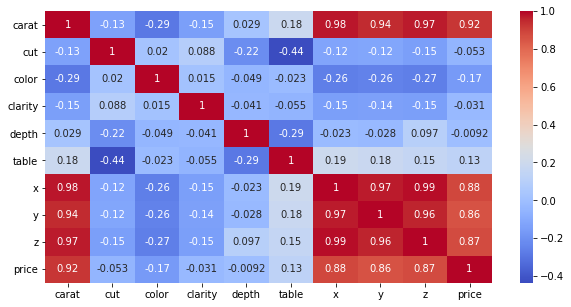

In [15]:
# Correlation between columns
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),annot = True , cmap = "coolwarm")

# Carat, x, y and z are highly correlated to the price

## 2. Defining X and y

In [16]:
# As cut will be used when training the model

In [17]:
X = df.drop([ "price"], 1)
y = df["price"]

In [30]:
X.shape

(40345, 9)

In [31]:
y.shape

(40345,)

## 3. Dividing X_train, X_test, y_train, y_test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 4)

## 4. Model selection

### Ensembling

In [30]:
# Voting
from sklearn.ensemble import VotingRegressor

rnd_clf = RandomForestRegressor(n_estimators=100, random_state=4)
svr_clf = SVR()
cat_clf = CatBoostRegressor(random_state=4)

estimators = [("forest", rnd_clf), ("svr", svr_clf), ("cat", cat_clf)]

voting_clf = VotingRegressor(estimators)
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (rnd_clf, svr_clf, cat_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, np.sqrt(mean_squared_error(y_test, y_pred)))


Learning rate set to 0.07244
0:	learn: 3733.3512397	total: 52.3ms	remaining: 52.3s
1:	learn: 3503.8391451	total: 56.3ms	remaining: 28.1s
2:	learn: 3287.1818672	total: 60.4ms	remaining: 20.1s
3:	learn: 3085.7360046	total: 64.4ms	remaining: 16s
4:	learn: 2903.1249970	total: 68.6ms	remaining: 13.6s
5:	learn: 2736.2377530	total: 72.8ms	remaining: 12.1s
6:	learn: 2578.4338070	total: 77.1ms	remaining: 10.9s
7:	learn: 2435.0019065	total: 81.5ms	remaining: 10.1s
8:	learn: 2302.9415363	total: 85.5ms	remaining: 9.41s
9:	learn: 2184.5575976	total: 89.6ms	remaining: 8.87s
10:	learn: 2069.3962950	total: 93.4ms	remaining: 8.4s
11:	learn: 1964.9266979	total: 97.8ms	remaining: 8.05s
12:	learn: 1870.7237315	total: 102ms	remaining: 7.75s
13:	learn: 1784.3330052	total: 106ms	remaining: 7.49s
14:	learn: 1702.1438742	total: 110ms	remaining: 7.24s
15:	learn: 1627.9935670	total: 114ms	remaining: 7.03s
16:	learn: 1558.5395104	total: 118ms	remaining: 6.84s
17:	learn: 1492.1560247	total: 122ms	remaining: 6.68s


In [ ]:
# VotingRegressor suggests that CatBoostRegressor is the most accurate model. In any case, we will still try different models without parameters for comparison

### Random Forest

In [187]:
pipe = Pipeline(steps=[
    ("classifier", RandomForestRegressor())
])

random_forest_params = {
    "classifier": [RandomForestRegressor()],
    "classifier__random_state": [4]
    #"classifier__n_estimators": [1, 10, 100],
    #"classifier__max_features": [1,2,3]
}

search_space = [random_forest_params]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 10,
                  verbose=1,
                  n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestRegressor(random_state=4)],
                          'classifier__random_state': [4]}],
             verbose=1)

In [188]:
clf = GridSearchCV(estimator=pipe, param_grid=search_space)

In [189]:
%%time
# Fit grid search
best_model = clf.fit(X_train, y_train)
# View best model
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_random_forest_1.sav'
pickle.dump(best_model, open(filename, 'wb'))

best estimator: RandomForestRegressor(random_state=4)
clf.best_params_ {'classifier': RandomForestRegressor(random_state=4), 'classifier__random_state': 4}
clf.best_score 0.979819972933251
Wall time: 34.6 s


### Polynominal 

### **!! This model takes 1:30h to process !!**

In [107]:
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {
    "polynomialfeatures__degree": np.arange(10),
    #"linearregression__fit_intercept": [True, False], 
    #"linearregression__normalize": [True, False]
}

poly_grid = GridSearchCV(PolynomialRegression(), 
                param_grid, 
                cv=10, 
                scoring="neg_mean_squared_error",
                verbose=1,
                n_jobs=-1)

clf_poly.fit(X_train, y_train)
clf_poly = GridSearchCV(PolynomialRegression(), param_grid)

In [108]:
%%time
# Fit grid search
best_model_poly = clf_poly.fit(X_train, y_train)
# View best model
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf_poly.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_poly.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_poly_1.sav'
pickle.dump(best_model_poly, open(filename, 'wb'))

C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Usuario\AppData\Loca

### SVR

In [109]:
pipe = Pipeline(steps=[
    ("classifier", SVR)
])

svr_params = {
    "classifier": [SVR()],
    "classifier__kernel": ("linear", "rbf", "poly")
    #"classifier__C": [1, 10, 100, 1000],
    
}

clf_svr = GridSearchCV(estimator = pipe,
                  param_grid = svr_params,
                  cv = 10,
                  verbose=1,
                  n_jobs=-1)

clf_svr.fit(X_train, y_train)
clf_svr = GridSearchCV(estimator=pipe, param_grid=search_space)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [110]:
%%time
# Fit grid search
best_model_svr = clf_svr.fit(X_train, y_train)
# View best model
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf_svr.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_svr.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_svr_1.sav'
pickle.dump(best_model_svr, open(filename, 'wb'))

best estimator: LinearRegression()
clf.best_params_ {'classifier': LinearRegression()}
clf.best_score 0.8784415219930309
Wall time: 56 ms


### Catboost

In [20]:
pipe = Pipeline(steps=[
    ("classifier", CatBoostRegressor())
])

catboost_params = {
    "classifier": [CatBoostRegressor()],
    "classifier__iterations": [100,200],
    "classifier__depth": [6,10],
    "classifier__l2_leaf_reg": [5,10,100],
    #"classifier__border_count": [10,20,50,100],
    #"classifier__random_strength": [0.2,0.5,0.8],
    "classifier__eval_metric": ["r2", "RMSE"],
    "classifier__od_type": ["IncToDec", "Iter"],
    "classifier__random_state": [4,42] 

}
                
clf_cat = GridSearchCV(estimator = pipe,
                  param_grid = catboost_params,
                  cv = 10,
                  verbose=2,
                  n_jobs=-1)

clf_cat.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.9534477  0.95364229 0.9534477  0.95364229 0.95260903 0.95281939
 0.95260903 0.95281939 0.94251927 0.94237945 0.94251927 0.94237945
 0.97219421 0.97211472 0.97219421 0.97211472 0.97145938 0.97142569
 0.97145938 0.97142569 0.96553133 0.96536572 0.96553133 0.96536572
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan    

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        <catboost.core.CatBoostRegressor object at 0x000001442AF2E6C8>)]),
             n_jobs=-1,
             param_grid={'classifier': [<catboost.core.CatBoostRegressor object at 0x000001442AF2ED48>],
                         'classifier__depth': [6, 10],
                         'classifier__eval_metric': ['r2', 'RMSE'],
                         'classifier__iterations': [100, 200],
                         'classifier__l2_leaf_reg': [5, 10, 100],
                         'classifier__od_type': ['IncToDec', 'Iter'],
                         'classifier__random_state': [4, 42]},
             verbose=2)

In [21]:
%%time
# Fit grid search
best_model_cat = clf_cat.fit(X_train, y_train)
# View best model
print("best estimator:", best_model_cat.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf_cat.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_cat.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_cat_1.sav'
pickle.dump(best_model_cat, open(filename, 'wb'))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
0:	learn: 3875.5816951	total: 21.8ms	remaining: 4.35s
1:	learn: 3770.7769129	total: 42.8ms	remaining: 4.24s
2:	learn: 3670.2294728	total: 62.7ms	remaining: 4.12s
3:	learn: 3572.4579568	total: 82ms	remaining: 4.02s
4:	learn: 3479.3962098	total: 102ms	remaining: 3.97s
5:	learn: 3388.1851609	total: 121ms	remaining: 3.92s
6:	learn: 3300.2747427	total: 142ms	remaining: 3.91s
7:	learn: 3214.4209608	total: 162ms	remaining: 3.89s
8:	learn: 3134.0194985	total: 182ms	remaining: 3.87s
9:	learn: 3052.0402464	total: 202ms	remaining: 3.84s
10:	learn: 2971.6240956	total: 223ms	remaining: 3.84s
11:	learn: 2894.1377345	total: 245ms	remaining: 3.84s
12:	learn: 2821.0277078	total: 267ms	remaining: 3.83s
13:	learn: 2748.7786700	total: 292ms	remaining: 3.88s
14:	learn: 2679.3959290	total: 311ms	remaining: 3.83s
15:	learn: 2613.3901144	total: 330ms	remaining: 3.79s
16:	learn: 2549.3884417	total: 350ms	remaining: 3.76s
17:	learn: 2485.9783058	tot

In [ ]:
# GridSearch suggests that the best model is RandomForestRegressor.

In [4]:
with open("model_cat_1.sav","rb") as f:
    loaded = pickle.load(f)

In [33]:
with open("model_random_forest_1.sav","rb") as f:
    loaded_model = pickle.load(f)

In [34]:
predictions = loaded_model.predict(X_test)
print(predictions)
np.sqrt(mean_squared_error(y_test, predictions))

[ 806.50372157 8600.00738311 1200.35565807 ... 3209.63049135 1098.53669906
  733.32505205]


554.7035419623857

In [35]:
print(f"Score with no parameters: {loaded_model.score(X_train, y_train)}")

Score with no parameters: 0.9939132884829335


In [19]:
# TRYING hyperparameters with a smaller train size to reduce the waiting time. If results are desirable the 80% of train data will be used to train the model. - STILL VSC KEPT CRASHING SO THIS ANALYSIS COULD NEVER BE COMPLETED.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 4)

pipe = Pipeline(steps=[
    ("classifier", RandomForestRegressor())
])

random_forest_params = {
    "classifier": [RandomForestRegressor()],
    "classifier__random_state": [4],
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_features": [1,2,3],
    "classifier__warm_start": [True],
    "classifier__criterion": ["mse", "mae"]

}

search_space = [random_forest_params]

clf_rf = GridSearchCV(estimator = pipe,
                  param_grid = random_forest_params,
                  cv = 10,
                  verbose=1,
                  n_jobs=-1)

clf_rf.fit(X_train, y_train)
clf_rf = GridSearchCV(estimator=pipe, param_grid=search_space)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


In [102]:
%%time
# Fit grid search
best_model_rf = clf_rf.fit(X_train, y_train)
# View best model
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf_rf.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_rf.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_random_forest_3.sav'
pickle.dump(best_model_rf, open(filename, 'wb'))

KeyboardInterrupt: 

In [20]:
# normalization
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
scaler.fit(X)
X_normalized = scaler.transform(X)
X_normalized

# train/test split
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_normalized, y, test_size=0.20, random_state=4)

In [26]:
loaded_model_n = loaded_model
loaded_model_n.fit = (X_train_n, y_train_n)
print(f"Score with no parameters but normalization: {loaded_model.score(X_train_n, y_train_n)}")
predictions_n = loaded_model_n.predict(X_test_n)
np.sqrt(mean_squared_error(y_test_n, predictions_n))

# Worse score with normalization, so it won't be used. 

Score with no parameters but normalization: -0.6557447424704888


5109.788492433531

In [ ]:
# As RandomForestRegressor couldn't be completed with hyperparamters other methods are tried.

In [27]:
# Bagging
from sklearn.ensemble import BaggingRegressor
estimator = RandomForestRegressor(random_state=4)

bag_clf = BaggingRegressor(
            base_estimator = estimator,
            n_estimators = 500,
            max_samples = 500,
            bootstrap = True,
            warm_start = True,
            random_state=4          
)

bag_clf.fit(X_train, y_train)

bag_clf.score(X_train, y_train)

predictions_b = loaded_model_n.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions_b))

570.8034828927966

In [ ]:
# Adaboosting

In [28]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import model_selection

num_trees = 30

kfold = model_selection.KFold(n_splits=10)
model = AdaBoostRegressor(n_estimators = num_trees, random_state=4)
res_abc = model_selection.cross_val_score(model, X, y, cv=kfold).mean()
model.fit(X_train, y_train)
model.score(X_train, y_train)

# less than other methods

0.8874790483221697

In [49]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor

num_trees = 100

model = GradientBoostingRegressor(n_estimators = num_trees, random_state=4)
res_gbc = model_selection.cross_val_score(model, X, y, cv=kfold).mean()
model.fit(X_train, y_train)
model.score(X_train, y_train)


0.9692634172987057

In [26]:
#XGBoost
from xgboost import XGBRegressor
from sklearn import model_selection

model_x = XGBRegressor(n_estimators = 100)
res_xgb = model_selection.cross_val_score(model_x, X, y, cv=10).mean()
model_x.fit(X_train, y_train)
model_x.score(X_train, y_train)
y_pred_x = model_x.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_x))

547.8848701243654

In [ ]:
# XGBoost is the best model in this analysis

## 5. Predictions with X_test

In [27]:
predictions = model_x.predict(X_test)
print(predictions)

[ 873.41   8656.276  1224.9258 ... 3027.173  1065.5933  787.5288]


## 6. RMSE

In [74]:
np.sqrt(mean_squared_error(y_test, predictions))

570.8034828927966

## 7. Train the model with all available data

In [28]:
X_pred = pd.read_csv("data/diamonds_test.csv", index_col = 0)
X_pred.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.30,Ideal,H,SI2,60.0,56.0,4.41,4.43,2.65
1,0.34,Ideal,D,IF,62.1,57.0,4.52,4.46,2.79
2,1.57,Very Good,I,VS2,60.3,58.0,7.58,7.55,4.56
3,0.31,Ideal,H,VS2,61.8,57.0,4.32,4.36,2.68
4,1.51,Good,I,VVS1,64.0,60.0,7.26,7.21,4.63


In [29]:
# Same transformations than before to X_pred are carried out

X_pred["cut"] = X_pred["cut"].replace({"Ideal": 5, "Premium": 4, "Very Good": 3, "Good": 2, "Fair": 1})

X_pred["color"] = X_pred["color"].replace({"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I":2, "J":1})

X_pred["clarity"] = X_pred["clarity"].replace({"I1": 1, "VVS1": 2, "SI2": 3, "SI1": 4, "IF": 5, "VS1":6, "VVS2":7, "VS2":8})


## 8. Prediction with all data

In [30]:
predictions_submit = model_x.predict(X_pred)
predictions_submit

array([  403.30923,  2010.7904 ,  8919.227  , ..., 14956.127  ,
       10589.223  ,   687.87317], dtype=float32)

## **Submission to Kaggle**


In [31]:
sample = pd.read_csv("data/sample_submission.csv")

In [32]:
sample.head()

,id,price
0,0,12132
1,1,11786
2,2,14684
3,3,15425
4,4,6724


In [33]:
submission = pd.DataFrame({"id": range(len(predictions_submit)), "price": predictions_submit})
submission

,id,price
0,0,403.309235
1,1,2010.790405
2,2,8919.226562
3,3,508.464600
4,4,9272.775391
...,...,...
13444,13444,4991.905273
13445,13445,463.065979
13446,13446,14956.126953
13447,13447,10589.222656


## 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.


In [34]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")

In [35]:
chequeator(submission)

You're ready to submit!
